In [1]:
import json
import os
from collections import defaultdict, Counter
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
from PIL import Image, ImageDraw

In [2]:
# Set dataset paths
ROOT_DIR = "/home/mehul/bdd_od/data"

LABEL_DIR = os.path.join(ROOT_DIR, "bdd100k_labels_release", "bdd100k", "labels")
IMAGE_DIR = os.path.join(ROOT_DIR,"bdd100k_images_100k", "bdd100k","images", "100k")

In [3]:
# Load label files
with open(os.path.join(LABEL_DIR, "bdd100k_labels_images_train.json")) as f:
    train_labels = json.load(f)

with open(os.path.join(LABEL_DIR, "bdd100k_labels_images_val.json")) as f:
    val_labels = json.load(f)

In [4]:
type(train_labels)

list

In [5]:
train_labels[0]

{'name': '0000f77c-6257be58.jpg',
 'attributes': {'weather': 'clear',
  'scene': 'city street',
  'timeofday': 'daytime'},
 'timestamp': 10000,
 'labels': [{'category': 'traffic light',
   'attributes': {'occluded': False,
    'truncated': False,
    'trafficLightColor': 'green'},
   'manualShape': True,
   'manualAttributes': True,
   'box2d': {'x1': 1125.902264,
    'y1': 133.184488,
    'x2': 1156.978645,
    'y2': 210.875445},
   'id': 0},
  {'category': 'traffic light',
   'attributes': {'occluded': False,
    'truncated': False,
    'trafficLightColor': 'green'},
   'manualShape': True,
   'manualAttributes': True,
   'box2d': {'x1': 1156.978645,
    'y1': 136.637417,
    'x2': 1191.50796,
    'y2': 210.875443},
   'id': 1},
  {'category': 'traffic sign',
   'attributes': {'occluded': False,
    'truncated': False,
    'trafficLightColor': 'none'},
   'manualShape': True,
   'manualAttributes': True,
   'box2d': {'x1': 1101.731743,
    'y1': 211.122087,
    'x2': 1170.79037,
    

In [6]:
def extract_class_counts(annotations):
    class_counter = Counter()
    for item in annotations:
        for label in item.get("labels", []):
            if "category" in label:
                class_counter[label["category"]] += 1
    return class_counter

train_class_counts = extract_class_counts(train_labels)
val_class_counts = extract_class_counts(val_labels)

# Convert to DataFrame for plotting
df_train = pd.DataFrame(train_class_counts.items(), columns=["Class", "Train Count"])
df_val = pd.DataFrame(val_class_counts.items(), columns=["Class", "Val Count"])
df_counts = pd.merge(df_train, df_val, on="Class", how="outer").fillna(0)
df_counts = df_counts.sort_values("Train Count", ascending=False)
df_counts


Class  Train Count  Val Count
2             car       713211     102506
4            lane       528643      75730
9    traffic sign       239686      34908
8   traffic light       186117      26885
3   drivable area       125723      17981
6          person        91349      13262
11          truck        29971       4245
1             bus        11672       1597
0            bike         7210       1007
7           rider         4517        649
5           motor         3002        452
10          train          136         15

<Figure size 1200x600 with 0 Axes>

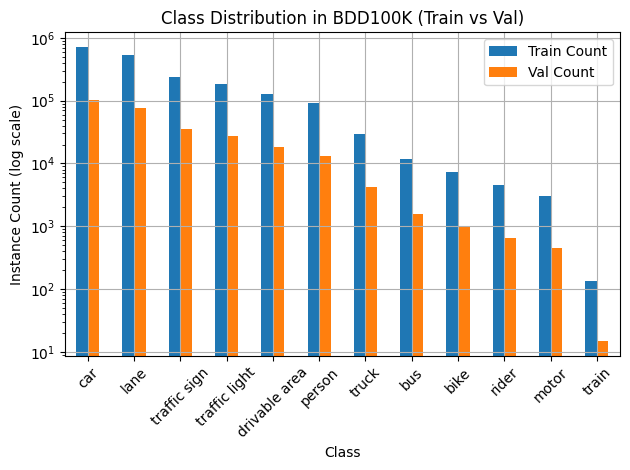

In [7]:
plt.figure(figsize=(12,6))
df_counts.set_index("Class")[["Train Count", "Val Count"]].plot(kind="bar", logy=True)
plt.title("Class Distribution in BDD100K (Train vs Val)")
plt.ylabel("Instance Count (log scale)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show();


Car , Lane and Traffic Sign has more counts and bike, rider, motor and train has least counts in the datasets.


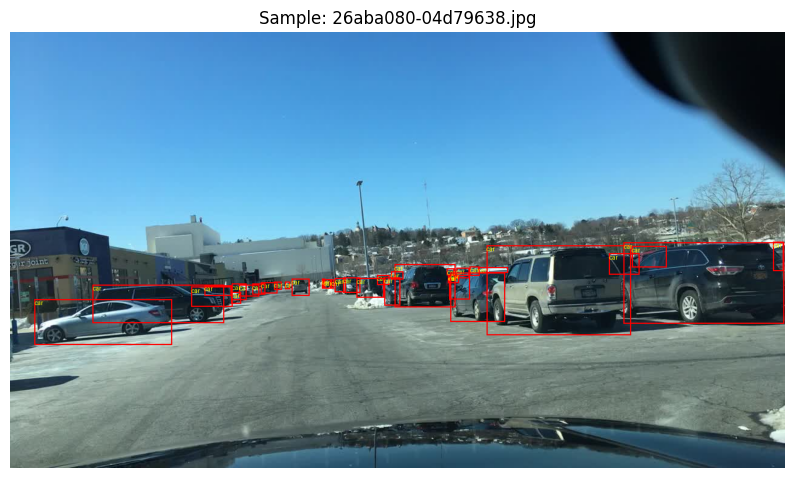

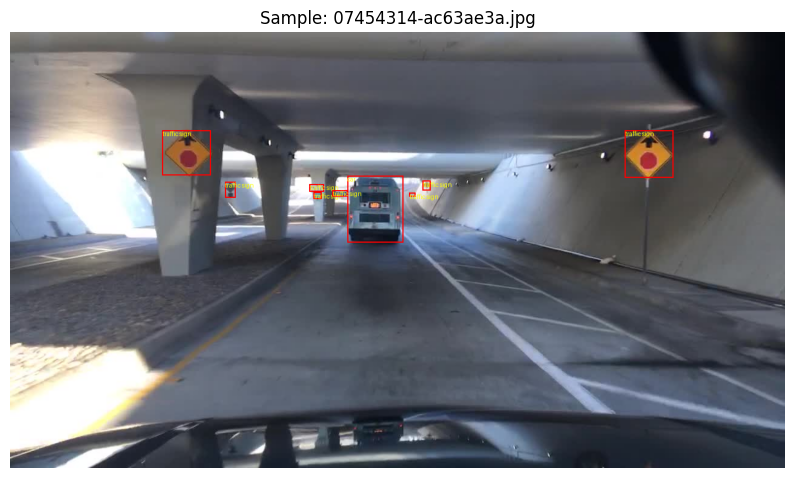

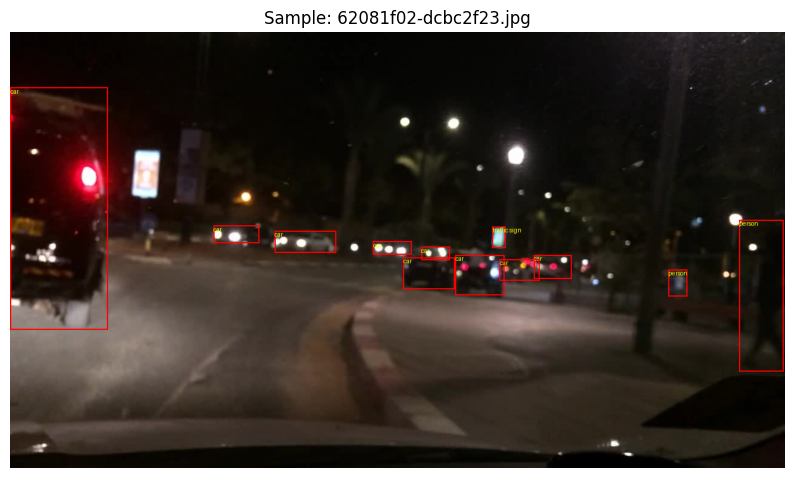

In [8]:
def show_sample_with_boxes(annotation, split="train"):
    image_path = os.path.join(IMAGE_DIR, split, annotation["name"])
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return

    image = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(image)

    for label in annotation.get("labels", []):
        if "box2d" in label:
            box = label["box2d"]
            x1, y1, x2, y2 = box["x1"], box["y1"], box["x2"], box["y2"]
            category = label.get("category", "N/A")
            draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
            draw.text((x1, y1), category, fill="yellow")

    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Sample: {annotation['name']}")
    plt.show()

# Show a few random samples
import random
for _ in range(3):
    sample = random.choice(train_labels)
    show_sample_with_boxes(sample, split="train")


Found 60516 scenes with >=15 objects


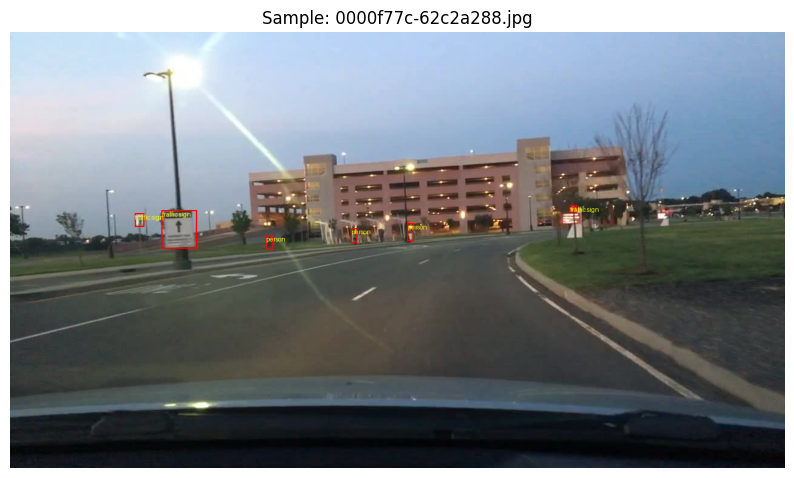

In [9]:
def find_dense_scenes(annotations, min_objects=10):
    return [item for item in annotations if len(item.get("labels", [])) >= min_objects]

dense_samples = find_dense_scenes(train_labels, min_objects=15)
print(f"Found {len(dense_samples)} scenes with >=15 objects")

# Show one dense scene
if dense_samples:
    show_sample_with_boxes(dense_samples[0], split="train")


In [10]:
def annotations_to_df(annotations, split="train"):
    data = []
    for item in annotations:
        image_name = item["name"]
        for label in item.get("labels", []):
            if "category" in label and "box2d" in label:
                box = label["box2d"]
                data.append({
                    "image": image_name,
                    "split": split,
                    "category": label["category"],
                    "x1": box["x1"],
                    "y1": box["y1"],
                    "x2": box["x2"],
                    "y2": box["y2"]
                })
    return pd.DataFrame(data)

df_train_boxes = annotations_to_df(train_labels, "train")
df_val_boxes = annotations_to_df(val_labels, "val")
df_all = pd.concat([df_train_boxes, df_val_boxes], ignore_index=True)
df_all.head()


image  split       category           x1          y1  \
0  0000f77c-6257be58.jpg  train  traffic light  1125.902264  133.184488   
1  0000f77c-6257be58.jpg  train  traffic light  1156.978645  136.637417   
2  0000f77c-6257be58.jpg  train   traffic sign  1101.731743  211.122087   
3  0000f77c-6257be58.jpg  train   traffic sign     0.000000    0.246631   
4  0000f77c-6257be58.jpg  train            car    45.240919  254.530367   

            x2          y2  
0  1156.978645  210.875445  
1  1191.507960  210.875443  
2  1170.790370  233.566141  
3   100.381647  122.825696  
4   357.805838  487.906215

In [12]:
TARGET_CLASSES = ["bike", "motor", "train"]
MAX_SAMPLES_PER_CLASS = 3

# Dictionary to store samples for each class
samples_by_class = {cls: [] for cls in TARGET_CLASSES}

In [13]:
samples_by_class

{'bike': [], 'motor': [], 'train': []}

In [14]:
# Search for relevant annotations
for ann in train_labels:
    found_classes = set(label["category"] for label in ann.get("labels", []))
    for cls in TARGET_CLASSES:
        if cls in found_classes and len(samples_by_class[cls]) < MAX_SAMPLES_PER_CLASS:
            samples_by_class[cls].append(ann)

In [15]:
samples_by_class

{'bike': [{'name': '000f8d37-d4c09a0f.jpg',
   'attributes': {'weather': 'undefined',
    'scene': 'city street',
    'timeofday': 'daytime'},
   'timestamp': 10000,
   'labels': [{'category': 'traffic light',
     'attributes': {'occluded': False,
      'truncated': False,
      'trafficLightColor': 'green'},
     'manualShape': True,
     'manualAttributes': True,
     'box2d': {'x1': 324.231803,
      'y1': 179.212372,
      'x2': 336.044295,
      'y2': 218.024845},
     'id': 659},
    {'category': 'traffic light',
     'attributes': {'occluded': False,
      'truncated': False,
      'trafficLightColor': 'green'},
     'manualShape': True,
     'manualAttributes': True,
     'box2d': {'x1': 771.418996,
      'y1': 160.649884,
      'x2': 788.293984,
      'y2': 199.462357},
     'id': 660},
    {'category': 'traffic light',
     'attributes': {'occluded': False,
      'truncated': False,
      'trafficLightColor': 'green'},
     'manualShape': True,
     'manualAttributes': True,


📸 Showing samples for class: BIKE


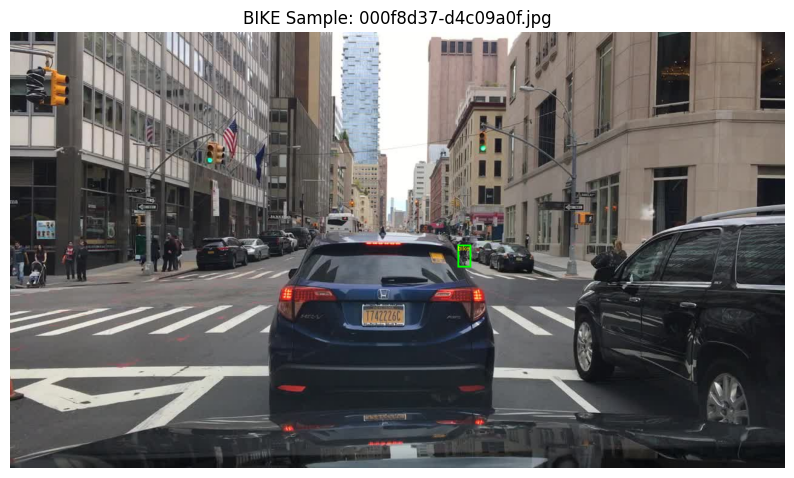

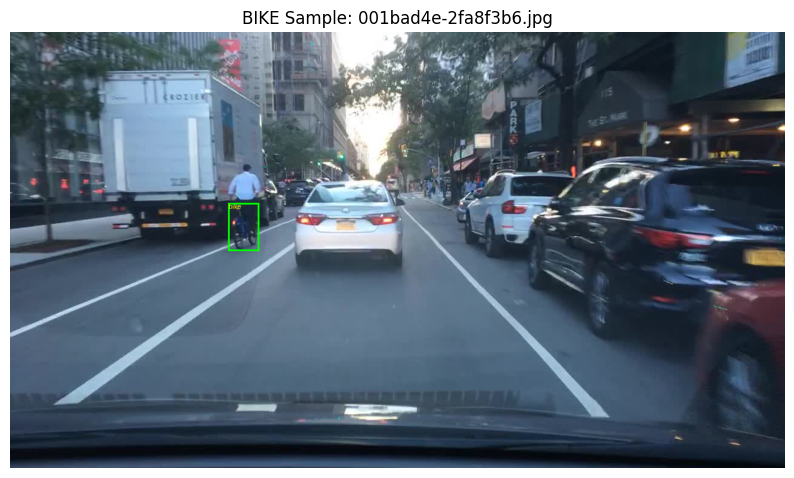

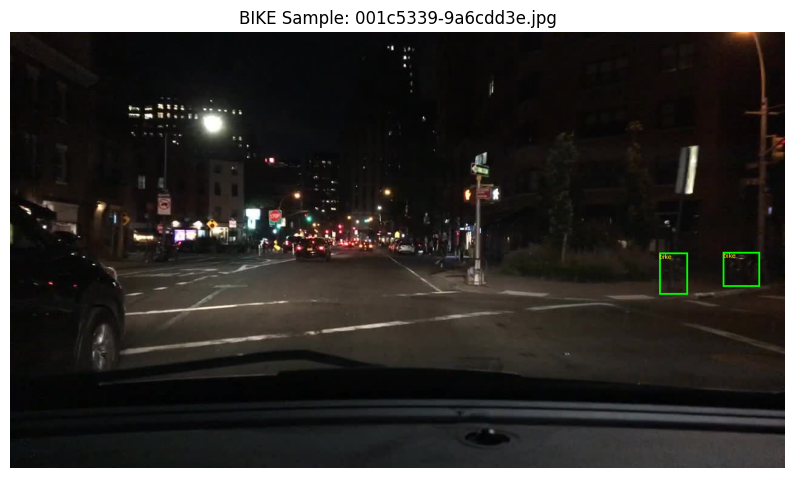


📸 Showing samples for class: MOTOR


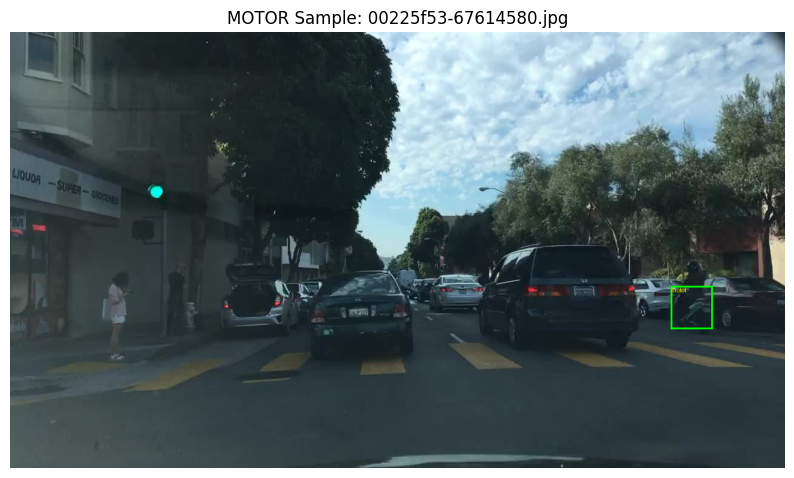

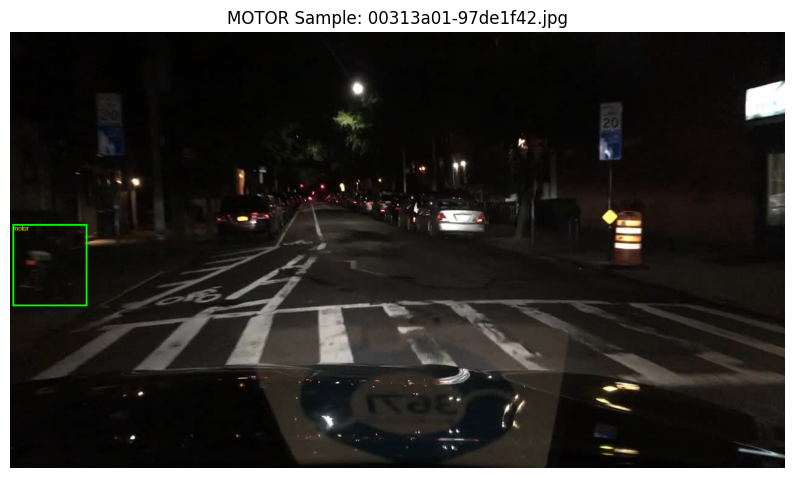

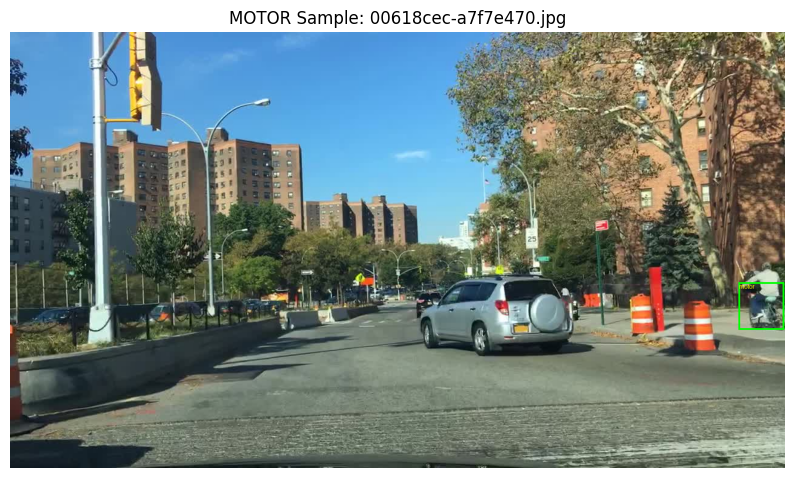


📸 Showing samples for class: TRAIN


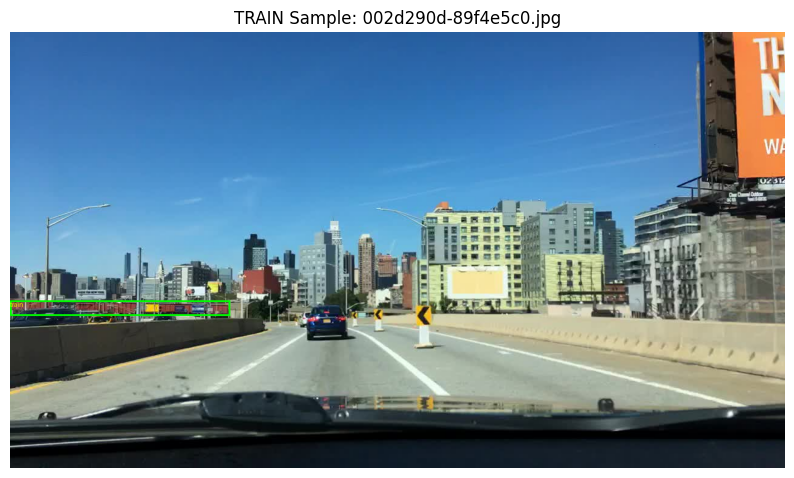

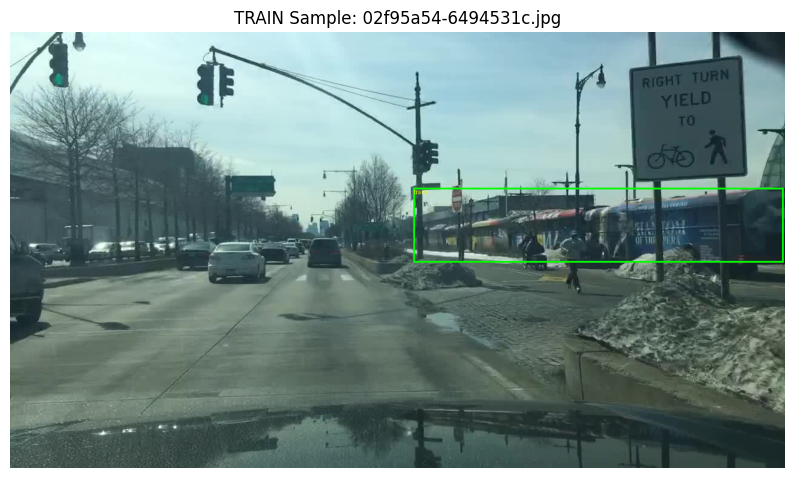

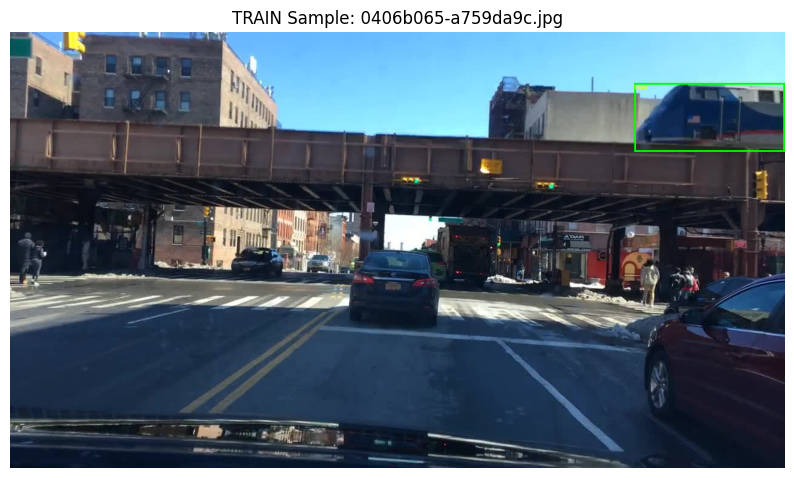

In [17]:
# Function to draw only boxes for the target class
def show_class_boxes(annotation, cls, split="train"):
    image_path = os.path.join(IMAGE_DIR, split, annotation["name"])

    if not os.path.exists(image_path):
        print(f"❌ Image not found: {image_path}")
        return

    image = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(image)

    for label in annotation.get("labels", []):
        if label.get("category") == cls and "box2d" in label:
            box = label["box2d"]
            x1, y1, x2, y2 = box["x1"], box["y1"], box["x2"], box["y2"]
            draw.rectangle([x1, y1, x2, y2], outline="lime", width=3)
            draw.text((x1, y1), cls, fill="yellow")

    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"{cls.upper()} Sample: {annotation['name']}")
    plt.show()

# Show samples
for cls in TARGET_CLASSES:
    print(f"\n📸 Showing samples for class: {cls.upper()}")
    for ann in samples_by_class[cls]:
        show_class_boxes(ann, cls, split="train")

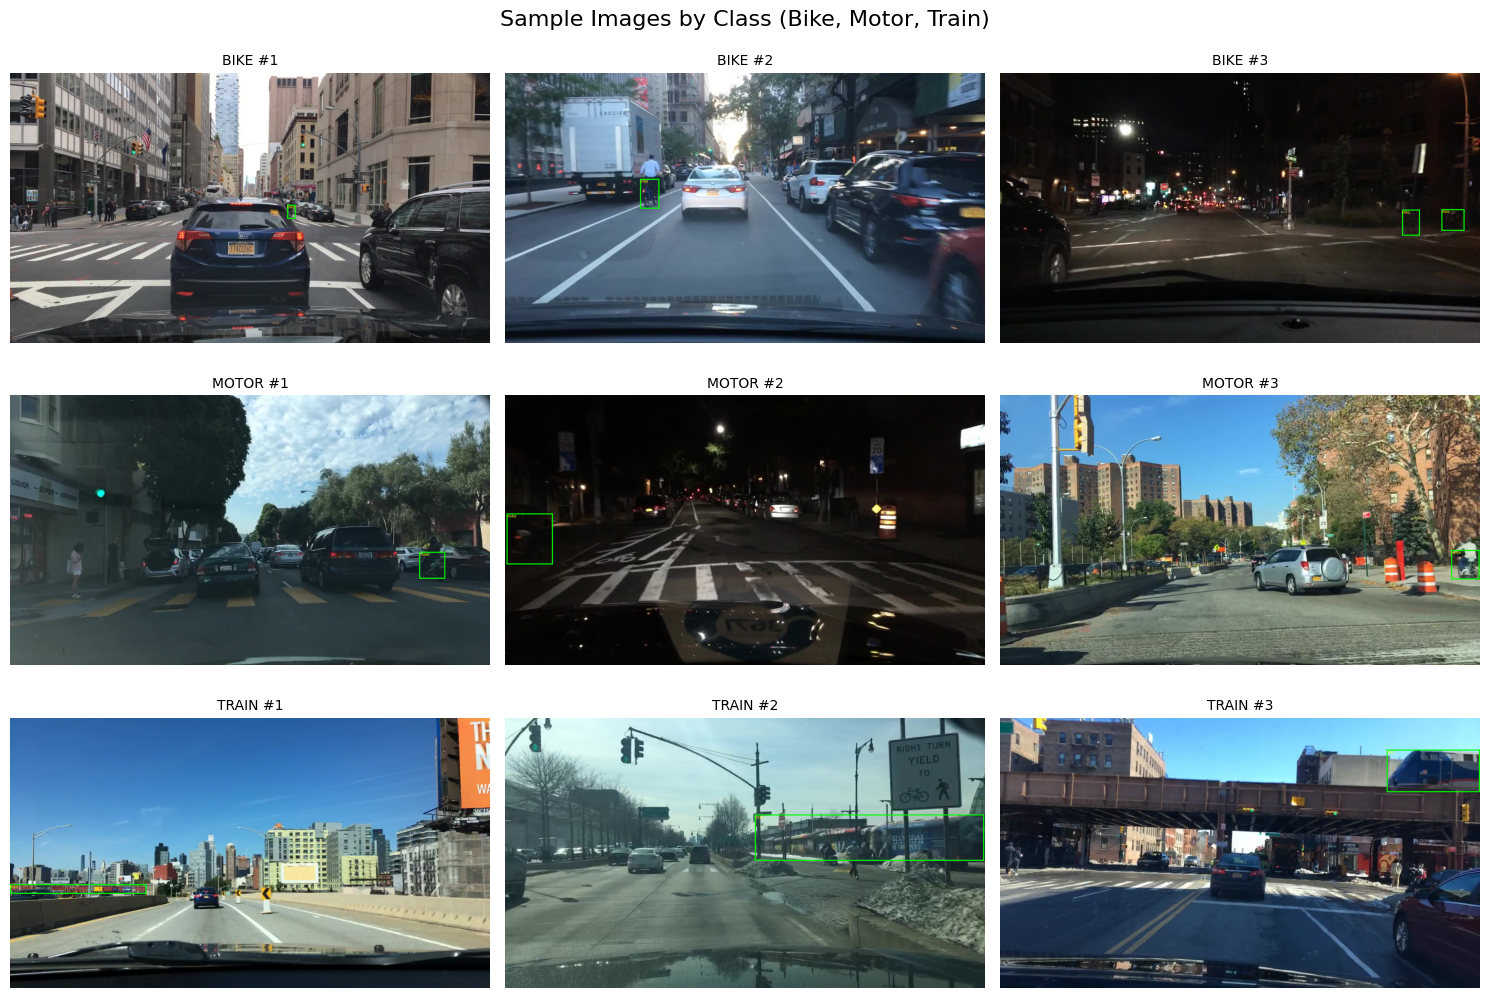

In [18]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import os

TARGET_CLASSES = ["bike", "motor", "train"]
MAX_SAMPLES_PER_CLASS = 3

# Collect samples
samples_by_class = {cls: [] for cls in TARGET_CLASSES}
for ann in train_labels:
    found_classes = set(label["category"] for label in ann.get("labels", []))
    for cls in TARGET_CLASSES:
        if cls in found_classes and len(samples_by_class[cls]) < MAX_SAMPLES_PER_CLASS:
            samples_by_class[cls].append(ann)

# Function to return PIL image with only class-specific boxes drawn
def get_image_with_boxes(annotation, cls, split="train"):
    image_path = os.path.join(IMAGE_DIR, split, annotation["name"])
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return None

    image = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(image)

    for label in annotation.get("labels", []):
        if label.get("category") == cls and "box2d" in label:
            box = label["box2d"]
            x1, y1, x2, y2 = box["x1"], box["y1"], box["x2"], box["y2"]
            draw.rectangle([x1, y1, x2, y2], outline="lime", width=3)
            draw.text((x1, y1), cls, fill="yellow")

    return image

# Create grid of images
fig, axes = plt.subplots(nrows=len(TARGET_CLASSES), ncols=MAX_SAMPLES_PER_CLASS, figsize=(15, 10))

for row, cls in enumerate(TARGET_CLASSES):
    for col in range(MAX_SAMPLES_PER_CLASS):
        ax = axes[row, col]
        try:
            ann = samples_by_class[cls][col]
            img = get_image_with_boxes(ann, cls, split="train")
            if img:
                ax.imshow(img)
                ax.set_title(f"{cls.upper()} #{col+1}", fontsize=10)
            else:
                ax.set_facecolor('gray')
                ax.set_title("Image not found")
        except IndexError:
            ax.set_facecolor('lightgray')
            ax.set_title("No sample")
        ax.axis('off')

plt.tight_layout()
plt.suptitle("Sample Images by Class (Bike, Motor, Train)", fontsize=16, y=1.02)
plt.show()


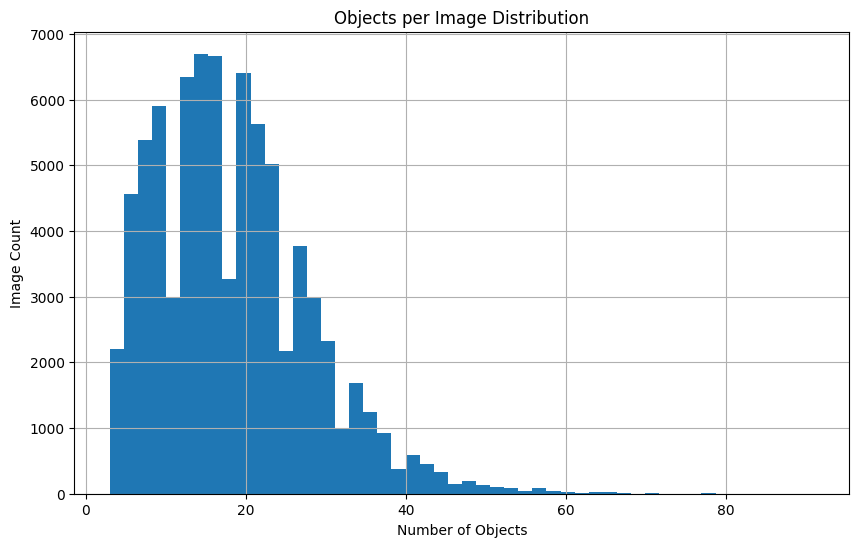

In [19]:
df_objects_per_image = df_all.groupby('image').size().reset_index(name='object_count')
plt.figure(figsize=(10,6))
plt.hist(df_objects_per_image['object_count'], bins=50)
plt.title('Objects per Image Distribution')
plt.xlabel('Number of Objects')
plt.ylabel('Image Count')
plt.grid(True)
plt.show()

In [20]:
df_all

image  split       category           x1          y1  \
0        0000f77c-6257be58.jpg  train  traffic light  1125.902264  133.184488   
1        0000f77c-6257be58.jpg  train  traffic light  1156.978645  136.637417   
2        0000f77c-6257be58.jpg  train   traffic sign  1101.731743  211.122087   
3        0000f77c-6257be58.jpg  train   traffic sign     0.000000    0.246631   
4        0000f77c-6257be58.jpg  train            car    45.240919  254.530367   
...                        ...    ...            ...          ...         ...   
1472392  fe1f55fa-19ba3600.jpg    val         person   491.615094  388.051507   
1472393  fe1f55fa-19ba3600.jpg    val         person   477.889798  361.848672   
1472394  fe1f55fa-19ba3600.jpg    val         person   583.948891  384.308246   
1472395  fe1f55fa-19ba3600.jpg    val         person   405.520064  408.015571   
1472396  fe1f55fa-19ba3600.jpg    val   traffic sign   366.839689  386.803753   

                  x2          y2  
0        1156.978645  210.875445  
1        1191.507960  210.875443  
2        1170.790370  233.566141  
3         100.381647  122.825696  
4         357.805838  487.906215  
...              ...         ...  
1472392   511.726280  444.314645  
1472393   496.606109  408.015571  
1472394   611.399480  431.722899  
1472395   415.502096  429.227390  
1472396   378.069475  401.776802  

[1472397 rows x 7 columns]

In [23]:
import numpy as np

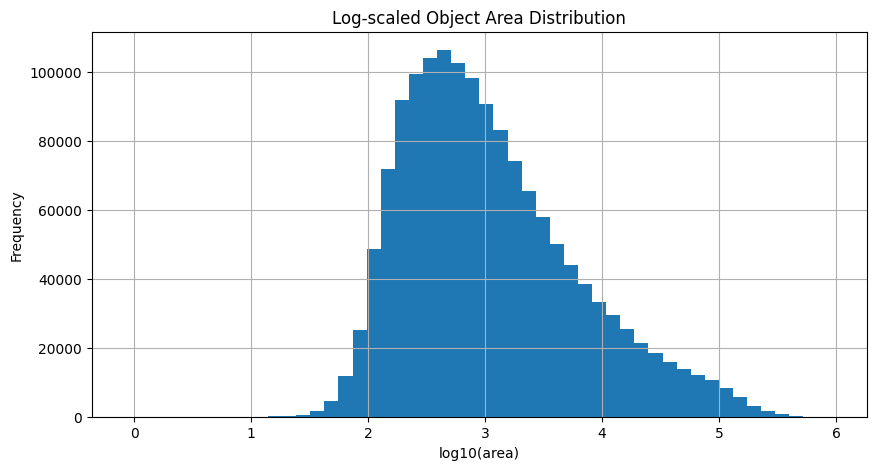

In [24]:
df_all["width"] = df_all["x2"] - df_all["x1"]
df_all["height"] = df_all["y2"] - df_all["y1"]
df_all["area"] = df_all["width"] * df_all["height"]

plt.figure(figsize=(10,5))
plt.hist(np.log10(df_all["area"]), bins=50)
plt.title("Log-scaled Object Area Distribution")
plt.xlabel("log10(area)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


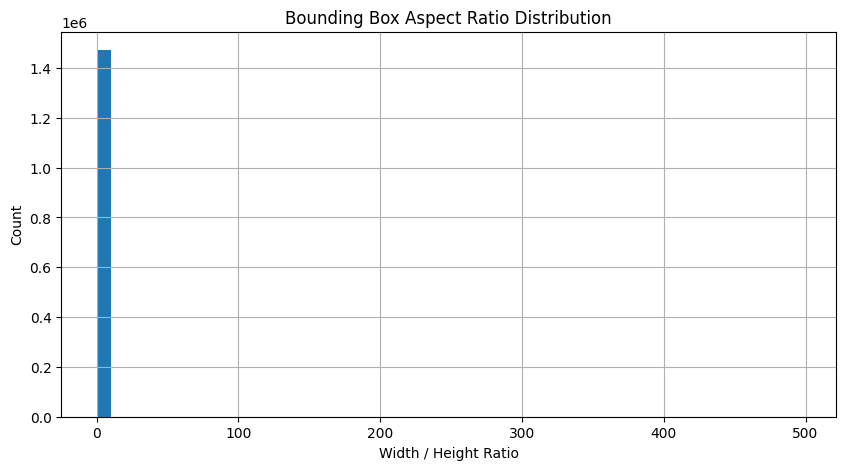

In [25]:
df_all["aspect_ratio"] = df_all["width"] / df_all["height"]
plt.figure(figsize=(10,5))
plt.hist(df_all["aspect_ratio"], bins=50)
plt.title("Bounding Box Aspect Ratio Distribution")
plt.xlabel("Width / Height Ratio")
plt.ylabel("Count")
plt.grid(True)
plt.show()


In [26]:
size_summary = df_all.groupby('category')[['width','height','area']].agg(['mean','median','std']).round(2)
display(size_summary.head(10))


width                  height                     area  \
                 mean  median     std    mean median     std      mean   
category                                                                 
bike            60.43   47.38   47.85   67.08  52.31   49.32   5862.64   
bus            145.39   92.26  142.54  126.91  70.09  145.62  35550.29   
car             74.57   41.34   86.38   58.00  33.78   66.51   9418.27   
motor           67.27   48.43   62.43   68.50  50.92   58.82   7612.30   
person          27.64   21.21   23.67   66.62  51.91   53.93   2936.76   
rider           43.42   30.37   40.03   82.12  59.05   74.29   6271.13   
traffic light   15.87   13.48   10.15   25.29  20.19   16.16    506.13   
traffic sign    32.29   23.96   29.69   25.21  18.75   20.64   1198.25   
train          269.25  132.26  327.76   83.71  41.14  105.34  37707.78   
truck          127.31   82.37  123.90  114.97  67.78  126.99  27727.85   

                                  
                median       std  
category                          
bike           2460.37  10503.70  
bus            6289.69  73017.29  
car            1378.99  24996.52  
motor          2487.91  16371.06  
person         1076.12   7581.37  
rider          1765.67  14120.63  
traffic light   262.92   1608.43  
traffic sign    444.23   4180.33  
train          5768.24  69493.69  
truck          5581.40  59094.12

In [29]:
import seaborn as sns

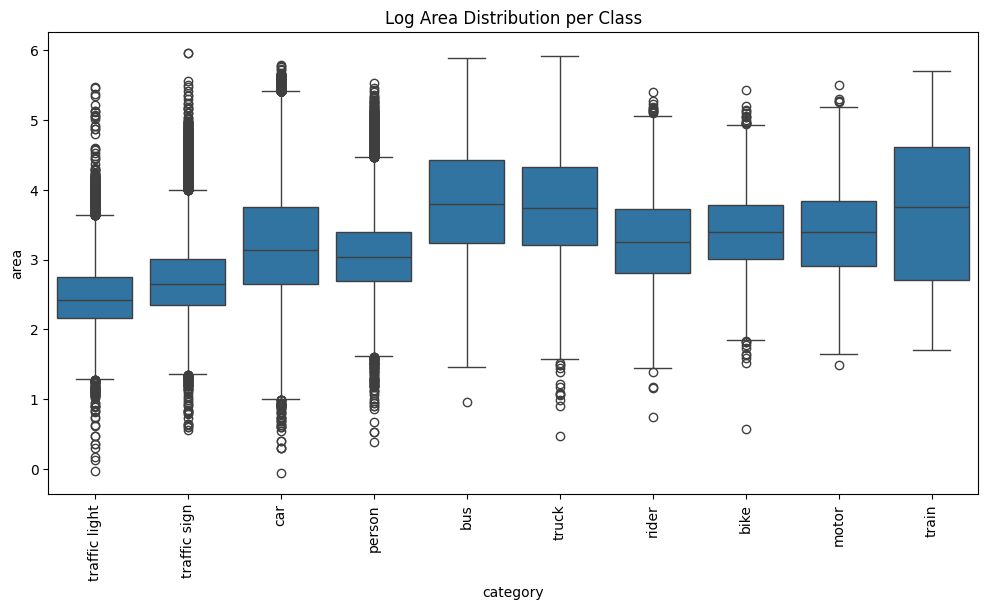

In [30]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df_all, x='category', y=np.log10(df_all['area']))
plt.xticks(rotation=90)
plt.title("Log Area Distribution per Class")
plt.show()


In [31]:
def extract_attributes(annotations):
    attr_list = []
    for item in annotations:
        attrs = item.get("attributes", {})
        attr_list.append({
            "image": item["name"],
            "weather": attrs.get("weather", "Unknown"),
            "timeofday": attrs.get("timeofday", "Unknown"),
            "scene": attrs.get("scene", "Unknown")
        })
    return pd.DataFrame(attr_list)

df_attrs_train = extract_attributes(train_labels)
df_attrs_val = extract_attributes(val_labels)
df_attrs_all = pd.concat([df_attrs_train, df_attrs_val])


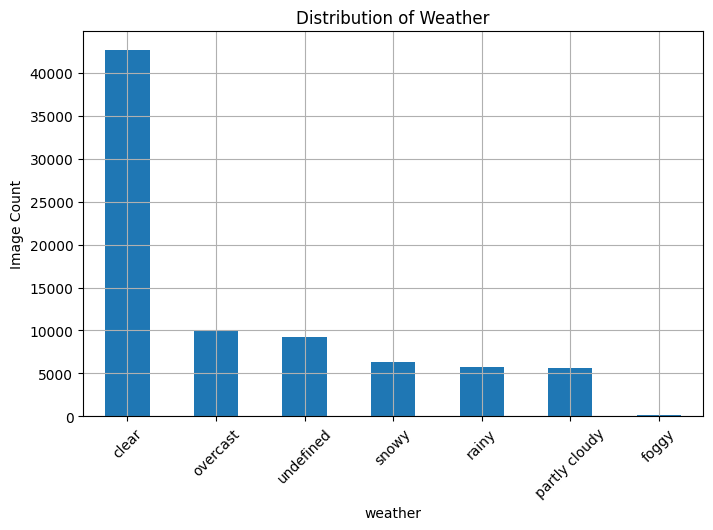

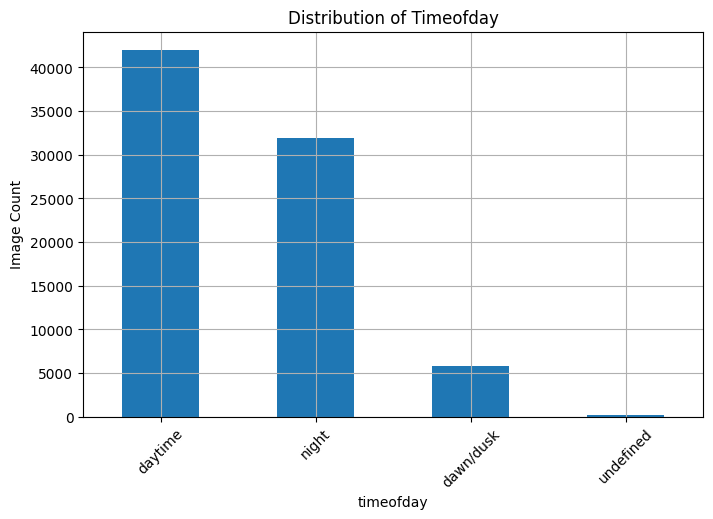

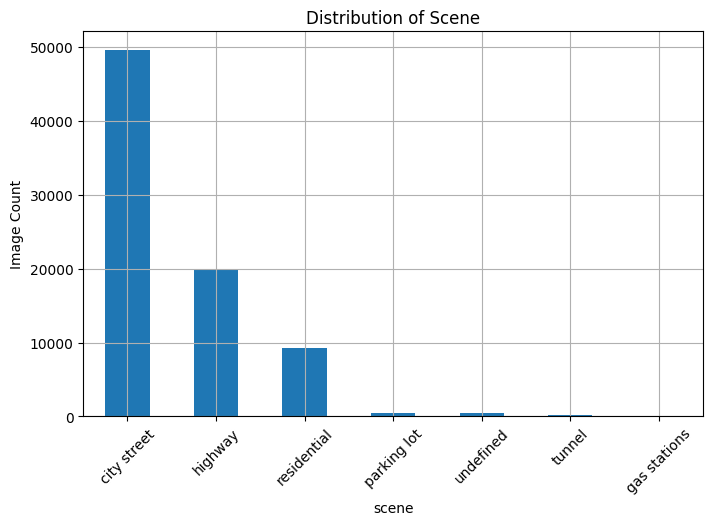

In [32]:
for col in ["weather", "timeofday", "scene"]:
    plt.figure(figsize=(8,5))
    df_attrs_all[col].value_counts().plot(kind='bar')
    plt.title(f"Distribution of {col.capitalize()}")
    plt.ylabel("Image Count")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()


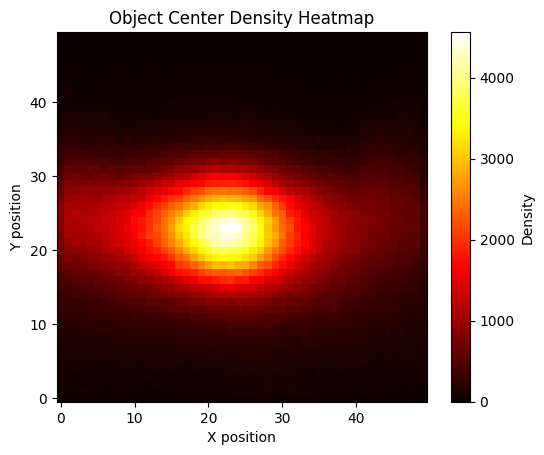

In [33]:
heatmap, xedges, yedges = np.histogram2d(
    (df_all["x1"] + df_all["x2"]) / 2,
    (df_all["y1"] + df_all["y2"]) / 2,
    bins=50
)
plt.imshow(heatmap.T, origin='lower', cmap='hot')
plt.title("Object Center Density Heatmap")
plt.xlabel("X position")
plt.ylabel("Y position")
plt.colorbar(label="Density")
plt.show()


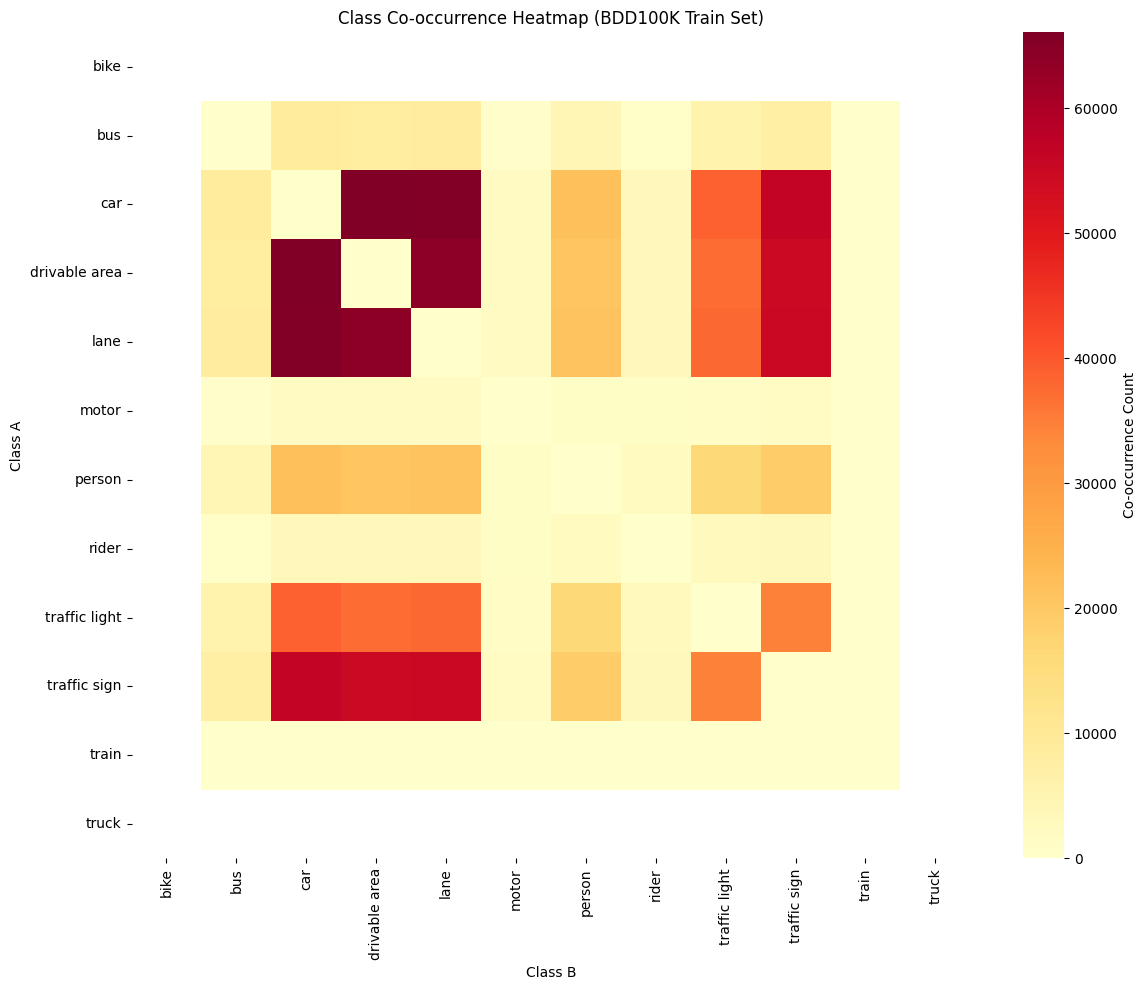

In [35]:
from itertools import combinations
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Count co-occurrences of classes in the same image
co_occurrence = Counter()
for ann in train_labels:
    cats = sorted(set(l['category'] for l in ann['labels'] if 'category' in l))
    for a, b in combinations(cats, 2):
        co_occurrence[(a, b)] += 1

# Convert to DataFrame
co_df = pd.DataFrame([
    {"class_a": a, "class_b": b, "count": c}
    for (a, b), c in co_occurrence.items()
])

# ✅ FIX: Use keyword arguments for pivot
pivot = co_df.pivot(index="class_a", columns="class_b", values="count").fillna(0)

# Make symmetric (since a,b = b,a)
pivot = pivot + pivot.T.fillna(0)

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(pivot, cmap="YlOrRd", cbar_kws={'label': 'Co-occurrence Count'})
plt.title("Class Co-occurrence Heatmap (BDD100K Train Set)")
plt.xlabel("Class B")
plt.ylabel("Class A")
plt.tight_layout()
plt.show()


In [36]:
import cv2
import random

sample_paths = random.sample(df_all['image'].unique().tolist(), 500)
means = []
for img_name in sample_paths:
    path = os.path.join(IMAGE_DIR, 'train', img_name)
    if os.path.exists(path):
        img = cv2.imread(path)
        means.append(img.mean(axis=(0,1)))
means = np.array(means)
print("Mean RGB:", means.mean(axis=0))


ModuleNotFoundError: No module named 'cv2'

In [38]:


# Sample a subset of images for efficiency
sample_paths = random.sample(df_all['image'].unique().tolist(), 500)
means = []
stds = []

for img_name in sample_paths:
    path = os.path.join(IMAGE_DIR, 'train', img_name)
    if os.path.exists(path):
        img = Image.open(path).convert("RGB")
        img_np = np.array(img) / 255.0  # normalize 0–1
        means.append(img_np.mean(axis=(0, 1)))
        stds.append(img_np.std(axis=(0, 1)))

means = np.array(means)
stds = np.array(stds)

mean_rgb = means.mean(axis=0)
std_rgb = stds.mean(axis=0)

print(f"Mean RGB (normalized 0–1): {mean_rgb}")
print(f"Std RGB (normalized 0–1): {std_rgb}")
print(f"Mean RGB (0–255 scale): {(mean_rgb*255).astype(int)}")


Mean RGB (normalized 0–1): [0.2726245  0.28798119 0.28701112]
Std RGB (normalized 0–1): [0.19522994 0.19619829 0.19984903]
Mean RGB (0–255 scale): [69 73 73]


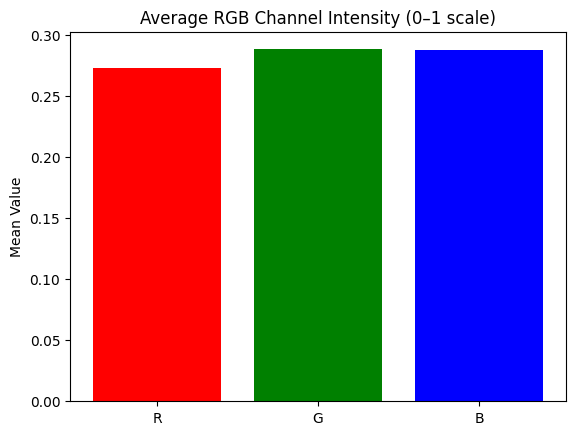

In [39]:


plt.bar(['R', 'G', 'B'], mean_rgb, color=['r', 'g', 'b'])
plt.title('Average RGB Channel Intensity (0–1 scale)')
plt.ylabel('Mean Value')
plt.show()
